In [87]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import lower, col, count, concat_ws
from pyspark.sql.types import Row
from pyspark import RDD
from typing import List, Tuple, Callable, Dict, Optional, Any, NamedTuple
import numpy as np
import scipy.stats as stats

spark = (SparkSession.builder.appName("pacdb")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", ".spark")
         .enableHiveSupport()
         .getOrCreate())

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"

plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

24/11/03 03:07:20 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [88]:
#@markdown Install dependencies and load data

import sys

from IPython.display import clear_output
clear_output()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [89]:
import pandas as pd

portuguese_df = pd.read_csv("./pipeline_dp/data/student_performance/student-por.csv", delimiter=";")
portuguese_df['ID'] = range(1, len(portuguese_df) + 1)

In [90]:
portuguese_df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,ID
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,4,0,11,11,1
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,2,9,11,11,2
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,6,12,13,12,3
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,0,14,14,14,4
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,0,11,13,13,5


In [91]:
portuguese_df['df'] = 'portuguese'

In [92]:
absences_mean = np.mean(portuguese_df['absences'])
absences_count = len(portuguese_df['absences'])
absences_sum = np.sum(portuguese_df['absences'])
absences_var = np.var(portuguese_df['absences'])

print(absences_mean,absences_count, absences_sum, absences_var)

3.6594761171032357 649 2375 21.503457968998173


In [93]:
eps_list = [0.2, 0.36, 0.4, 0.6, 0.73, 0.8, 1, 1.2, 1.4, 1.64, 1.8, 2, 3, 4, 5, 6, 7, 8, 9, 10]
import pipeline_dp
from pipeline_dp.aggregate_params import AggregateParams
from pipeline_dp.data_extractors import DataExtractors
from pipeline_dp import budget_accounting
import pipeline_dp.aggregate_params as aggregate_params
from pipeline_dp.dp_engine import DPEngine
import pipeline_dp.pipeline_backend as pipeline_backend
from tests import dp_engine_test
rows = [index_row[1] for index_row in portuguese_df.iterrows()]

In [94]:
data_extractors = DataExtractors(
   partition_extractor=lambda row: row.df, 
   privacy_id_extractor=lambda row: row.absences,
   value_extractor=lambda row: 1)

In [95]:
# get 500 Noisy Mean

params = AggregateParams(
   noise_kind=pipeline_dp.NoiseKind.GAUSSIAN,
   metrics=[pipeline_dp.Metrics.MEAN],
   min_value=0,
   max_value=10,
   max_partitions_contributed=1,
   max_contributions_per_partition=1
)

all_noisy_means = []
for eps in eps_list:
    noisy_mean_per_eps = []
    for i in range(500):
        backend = pipeline_backend.LocalBackend()
        budget_accountant = budget_accounting.NaiveBudgetAccountant(total_epsilon=eps, total_delta=1e-6)
        dp_engine = DPEngine(budget_accountant, backend)

        dp_result = dp_engine.aggregate(rows, params, data_extractors)
        budget_accountant.compute_budgets()
        dp_result = list(dp_result)
        
        noisy_mean_per_eps.append(dp_result)
    all_noisy_means.append(noisy_mean_per_eps)


In [96]:
noisy_means = []
for noisy_list in all_noisy_means:
    noisy_mean_per_eps = []
    for item in noisy_list:
        if item:
            noisy_result = item[0][1].mean
        else:
            noisy_result = 0
        noisy_mean_per_eps.append(noisy_result)
    noisy_means.append(noisy_mean_per_eps)
print(noisy_means)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [97]:
len(noisy_means)

20

In [98]:
import numpy as np

all_abs_errors_per_eps = []
all_relative_errors_per_eps = []
for noisy_list_per_eps in noisy_means:
    absolute_errors = [abs(noisy_mean - absences_mean) for noisy_mean in noisy_list_per_eps]
    relative_errors = [(abs(noisy_mean - absences_mean) / absences_mean) * 100 for noisy_mean in noisy_list_per_eps]
    all_abs_errors_per_eps.append(absolute_errors)
    all_relative_errors_per_eps.append(relative_errors)


In [99]:
import statistics

abs_errors_mean = []
for all_errors in all_abs_errors_per_eps:
    avg_abs_error = statistics.mean(all_errors)
    abs_errors_mean.append(avg_abs_error)

In [100]:
relative_errors_mean = []
for all_errors in all_relative_errors_per_eps:
    avg_relative_error = statistics.mean(all_errors)
    relative_errors_mean.append(avg_relative_error)

In [101]:
# get 500 Noisy Count

params = AggregateParams(
   noise_kind=pipeline_dp.NoiseKind.GAUSSIAN,
   metrics=[pipeline_dp.Metrics.COUNT],
   min_value=0,
   max_value=1000,
   max_partitions_contributed=1,
   max_contributions_per_partition=1
)

all_noisy_counts = []
for eps in eps_list:
   noisy_count_per_eps = []
   for i in range(500):
      backend = pipeline_backend.LocalBackend()
      budget_accountant = budget_accounting.NaiveBudgetAccountant(total_epsilon=eps, total_delta=1e-6)
      dp_engine = DPEngine(budget_accountant, backend)

      dp_result = dp_engine.aggregate(rows, params, data_extractors)
      budget_accountant.compute_budgets()
      dp_result = list(dp_result)
      
      noisy_count_per_eps.append(dp_result)
   all_noisy_counts.append(noisy_count_per_eps)


In [102]:
noisy_counts = []
for noisy_list in all_noisy_counts:
    noisy_count_per_eps = []
    for item in noisy_list:
        if item:
            noisy_result = item[0][1].count
        else:
            noisy_result = 0
        noisy_count_per_eps.append(noisy_result)
    noisy_counts.append(noisy_count_per_eps)

all_abs_errors_per_eps = []
all_relative_errors_per_eps = []
for noisy_list_per_eps in noisy_counts:
    absolute_errors = [abs(noisy_count - absences_count) for noisy_count in noisy_list_per_eps]
    relative_errors = [(abs(noisy_count - absences_count) / absences_count) * 100 for noisy_count in noisy_list_per_eps]
    all_abs_errors_per_eps.append(absolute_errors)
    all_relative_errors_per_eps.append(relative_errors)

import statistics

abs_errors_count = []
for all_errors in all_abs_errors_per_eps:
    avg_abs_error = statistics.mean(all_errors)
    abs_errors_count.append(avg_abs_error)

relative_errors_count = []
for all_errors in all_relative_errors_per_eps:
    avg_relative_error = statistics.mean(all_errors)
    relative_errors_count.append(avg_relative_error)

# eps_list, abs_errors_count, relative_errors_count

In [103]:
# get 500 Noisy Sum

params = AggregateParams(
   noise_kind=pipeline_dp.NoiseKind.GAUSSIAN,
   metrics=[pipeline_dp.Metrics.SUM],
   min_value=0,
   max_value=3000,
   max_partitions_contributed=1,
   max_contributions_per_partition=1
)

all_noisy_sum = []
for eps in eps_list:
   noisy_sum_per_eps = []
   for i in range(500):
      backend = pipeline_backend.LocalBackend()
      budget_accountant = budget_accounting.NaiveBudgetAccountant(total_epsilon=eps, total_delta=1e-6)
      dp_engine = DPEngine(budget_accountant, backend)

      dp_result = dp_engine.aggregate(rows, params, data_extractors)
      budget_accountant.compute_budgets()
      dp_result = list(dp_result)
      
      noisy_sum_per_eps.append(dp_result)
   all_noisy_sum.append(noisy_sum_per_eps)


In [104]:
noisy_sum = []
for noisy_list in all_noisy_sum:
    noisy_sum_per_eps = []
    for item in noisy_list:
        if item:
            noisy_result = item[0][1].sum
        else:
            noisy_result = 0
        noisy_sum_per_eps.append(noisy_result)
    noisy_sum.append(noisy_sum_per_eps)

all_abs_errors_per_eps = []
all_relative_errors_per_eps = []
for noisy_list_per_eps in noisy_sum:
    absolute_errors = [abs(noisy_sum - absences_sum) for noisy_sum in noisy_list_per_eps]
    relative_errors = [(abs(noisy_sum - absences_sum) / absences_sum) * 100 for noisy_sum in noisy_list_per_eps]
    all_abs_errors_per_eps.append(absolute_errors)
    all_relative_errors_per_eps.append(relative_errors)

abs_errors_sum = []
for all_errors in all_abs_errors_per_eps:
    avg_abs_error = np.mean(all_errors)
    abs_errors_sum.append(avg_abs_error)

relative_errors_sum = []
for all_errors in all_relative_errors_per_eps:
    avg_relative_error = np.mean(all_errors)
    relative_errors_sum.append(avg_relative_error)

# eps_list, abs_errors_count, relative_errors_count

In [105]:
# get 500 Noisy Var

params = AggregateParams(
   noise_kind=pipeline_dp.NoiseKind.GAUSSIAN,
   metrics=[pipeline_dp.Metrics.VARIANCE],
   min_value=0,
   max_value=100,
   max_partitions_contributed=1,
   max_contributions_per_partition=1
)

all_noisy_var = []
for eps in eps_list:
   noisy_var_per_eps = []
   for i in range(500):
      backend = pipeline_backend.LocalBackend()
      budget_accountant = budget_accounting.NaiveBudgetAccountant(total_epsilon=eps, total_delta=1e-6)
      dp_engine = DPEngine(budget_accountant, backend)

      dp_result = dp_engine.aggregate(rows, params, data_extractors)
      budget_accountant.compute_budgets()
      dp_result = list(dp_result)
      
      noisy_var_per_eps.append(dp_result)
   all_noisy_var.append(noisy_var_per_eps)


In [106]:
noisy_var = []
for noisy_list in all_noisy_var:
    noisy_var_per_eps = []
    for item in noisy_list:
        if item:
            noisy_result = item[0][1].variance
        else:
            noisy_result = 0
        noisy_var_per_eps.append(noisy_result)
    noisy_var.append(noisy_var_per_eps)

all_abs_errors_per_eps = []
all_relative_errors_per_eps = []
for noisy_list_per_eps in noisy_var:
    absolute_errors = [abs(noisy_var - absences_var) for noisy_var in noisy_list_per_eps]
    relative_errors = [(abs(noisy_var - absences_var) / absences_var) * 100 for noisy_var in noisy_list_per_eps]
    all_abs_errors_per_eps.append(absolute_errors)
    all_relative_errors_per_eps.append(relative_errors)

abs_errors_var = []
for all_errors in all_abs_errors_per_eps:
    avg_abs_error = np.mean(all_errors)
    abs_errors_var.append(avg_abs_error)

relative_errors_var = []
for all_errors in all_relative_errors_per_eps:
    avg_relative_error = np.mean(all_errors)
    relative_errors_var.append(avg_relative_error)

# eps_list, abs_errors_count, relative_errors_count

In [107]:
len(relative_errors_var)

20

In [108]:
# Create a DataFrame from lists
df = pd.DataFrame({
    'Epsilon': eps_list,
    'Average Absolute Error over 500 Samples - Count': abs_errors_count,
    'Average Relative Error over 500 Samples - Count': relative_errors_count,
    'Average Absolute Error over 500 Samples - Sum': abs_errors_sum,
    'Average Relative Error over 500 Samples - Sum': relative_errors_sum,
    'Average Absolute Error over 500 Samples - Mean': abs_errors_mean,
    'Average Relative Error over 500 Samples - Mean': relative_errors_mean,
    'Average Absolute Error over 500 Samples - Var': abs_errors_var,
    'Average Relative Error over 500 Samples - Var': relative_errors_var,
})


In [109]:
df.head(20)

,Epsilon,Average Absolute Error over 500 Samples - Count,Average Relative Error over 500 Samples - Count,Average Absolute Error over 500 Samples - Sum,Average Relative Error over 500 Samples - Sum,Average Absolute Error over 500 Samples - Mean,Average Relative Error over 500 Samples - Mean,Average Absolute Error over 500 Samples - Var,Average Relative Error over 500 Samples - Var
0,0.20,649.000000,100.000000,2375.000000,100.000000,3.659476,100.000000,21.503458,1.000000e+02
1,0.36,649.000000,100.000000,2375.000000,100.000000,3.659476,100.000000,21.503458,1.000000e+02
2,0.40,649.000000,100.000000,2375.000000,100.000000,3.659476,100.000000,706.289152,3.284538e+03
3,0.60,648.987307,99.998044,2568.475489,108.146336,3.659476,100.000000,23.773804,1.105580e+02
4,0.73,648.778825,99.965921,2566.490870,108.062773,3.659476,100.000000,2192.401115,1.019557e+04
5,0.80,648.850456,99.976958,2642.758279,111.274033,3.653393,99.833758,55680.888601,2.589392e+05
6,1.00,646.364043,99.593843,4114.417986,173.238652,3.662115,100.072118,86391.919497,4.017583e+05
7,1.20,629.707797,97.027396,13674.882115,575.784510,3.658142,99.963549,304880.584597,1.417821e+06
8,1.40,625.961515,96.450156,13801.675950,581.123198,3.728165,101.877018,213048.818127,9.907654e+05
9,1.64,625.134788,96.322772,13269.137538,558.700528,3.588979,98.073580,181565.926162,8.443569e+05


In [110]:
df.to_csv('all_results_table.txt', sep='\t', index=False)

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

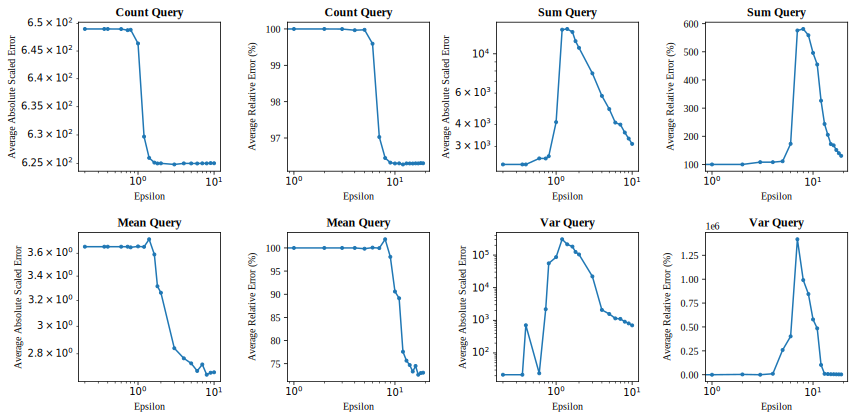

In [111]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = ['Count', 'Sum', 'Mean', 'Var']

for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Avg Absolute Scaled Error
    ax1.plot(df['Epsilon'], df[f'Average Absolute Error over 500 Samples - {query}'], label=query, marker='.')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('Epsilon')
    ax1.set_ylabel('Average Absolute Scaled Error')

    # Plotting Avg Relative Error (%)
    ax2.plot(df['Epsilon'].index, df[f'Average Relative Error over 500 Samples - {query}'], label=query, marker='.')
    ax2.set_xscale('log')
    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('Epsilon')
    ax2.set_ylabel('Average Relative Error (%)')

plt.tight_layout()
plt.show()